In [ ]:
#A2C MOUNTAIN CAR

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
from torch.distributions import Categorical
import time

# Actor Network
# Çevrede hangi eylemi yapacağını öğrenmek için kullanılan ağ
class Actor(nn.Module):
    def __init__(self, input_size, num_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Girdi boyutu kadar nöron alır, 64 nöronlu bir katmana bağlanır
        self.fc2 = nn.Linear(64, num_actions)  # 64 nörondan çıktı olarak hareket sayısı kadar düğüm çıkar

    def forward(self, x):
        x = F.relu(self.fc1(x))  # İlk katmanda ReLU aktivasyon fonksiyonu kullanılır
        x = F.softmax(self.fc2(x), dim=-1)  # Eylem olasılıklarını softmax ile normalize eder dim=-1: Son boyutu ifade eder,
        return x

# Critic Network
# Durumun değerini (value function) tahmin eder
class Critic(nn.Module):
    def __init__(self, input_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Girdi boyutu kadar nöron alır, 64 nöronlu bir katmana bağlanır
        self.fc2 = nn.Linear(64, 1)  # Çıkışta tek bir değer üretir (durumun değeri)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # İlk katmanda ReLU aktivasyon fonksiyonu kullanılır
        x = self.fc2(x)  # Çıkış katmanı
        return x

# Actor-Critic Eğitim Döngüsü
def actor_critic(actor, critic, episodes, max_steps=200, gamma=0.99, lr_actor=1e-3, lr_critic=1e-3):
    # Actor ve Critic için optimizasyon algoritmalarını tanımlıyoruz
    optimizer_actor = optim.AdamW(actor.parameters(), lr=lr_actor)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=lr_critic)

    # Eğitim istatistiklerini kaydetmek için bir sözlük oluşturuyoruz
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    # MountainCar-v0 ortamını oluşturuyoruz
    env = gym.make('MountainCar-v0')
    input_size = env.observation_space.shape[0]  # Ortamın durum (state) boyutu
    num_actions = env.action_space.n  # Eylem (action) sayısı

    for episode in range(1, episodes + 1):  # Her bölüm için döngü başlatılır
        state = env.reset()[0]  # Başlangıç durumu alınıyor
        ep_return = 0  # Bu bölümdeki toplam ödül
        done = False  # Bölümün bitiş durumu
        step_count = 0  # Adım sayacı

        while not done and step_count < max_steps:  # Bölüm tamamlanmadığı sürece çalışır
            state_tensor = torch.FloatTensor(state)  # Durumu PyTorch tensörüne çeviriyoruz

            # Actor ağından eylem olasılıklarını alıyoruz
            action_probs = actor(state_tensor)
            dist = Categorical(action_probs)  # Olasılık dağılımını oluşturuyoruz
            action = dist.sample()  # Dağılımdan bir eylem seçiyoruz

            # Seçilen eylemi çevrede gerçekleştiriyoruz
            next_state, reward, done, _, _ = env.step(action.item())

            # Critic ağını kullanarak durumların değerlerini hesaplıyoruz
            value = critic(state_tensor)  # Mevcut durumun değeri
            next_value = critic(torch.FloatTensor(next_state))  # Sonraki durumun değeri

            # TD Hedefini ve avantajı (advantage) hesaplıyoruz
            td_target = reward + gamma * next_value * (1 - done)  # TD Hedefi
            advantage = td_target - value  # Avantaj

            # Critic ağını güncellemek için kayıp fonksiyonu ve optimizasyon
            critic_loss = F.mse_loss(value, td_target.detach())  # MSE kayıp fonksiyonu
            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()

            # Actor ağını güncellemek için kayıp fonksiyonu ve optimizasyon
            log_prob = dist.log_prob(action)  # Seçilen eylemin logaritmik olasılığı
            actor_loss = -log_prob * advantage.detach()  # Politika gradyan kaybı
            optimizer_actor.zero_grad()
            actor_loss.backward()
            optimizer_actor.step()

            # Durumu ve ödülleri güncelliyoruz
            state = next_state  # Sonraki durum, mevcut durum olarak atanır
            ep_return += reward  # Ödül toplanır
            step_count += 1  # Adım sayacı artırılır

        # Her bölüm için istatistikleri kaydediyoruz
        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return)

        # Bölüm istatistiklerini ekrana yazdırıyoruz
        print(f"Episode {episode}: Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}, Return: {ep_return}, Steps: {step_count}")

    env.close()  # Ortamı kapatıyoruz
    return stats  # Eğitim istatistiklerini döndürüyoruz

# Actor ve Critic modellerini oluşturuyoruz
actor = Actor(input_size=2, num_actions=3)  # MountainCar'da 2 durum değişkeni ve 3 eylem bulunur
critic = Critic(input_size=2)

# Modeli eğitmek için aktör-eleştirmen algoritmasını çağırıyoruz
stats = actor_critic(actor, critic, episodes=1000)


Episode 1: Actor Loss: -1.0046, Critic Loss: 0.8614, Return: -200.0, Steps: 200
Episode 2: Actor Loss: -0.8852, Critic Loss: 0.6609, Return: -200.0, Steps: 200
Episode 3: Actor Loss: -0.4589, Critic Loss: 0.2829, Return: -200.0, Steps: 200
Episode 4: Actor Loss: 0.0416, Critic Loss: 0.0013, Return: -200.0, Steps: 200
Episode 5: Actor Loss: -0.3007, Critic Loss: 0.1049, Return: -200.0, Steps: 200
Episode 6: Actor Loss: -1.2726, Critic Loss: 0.9460, Return: -200.0, Steps: 200
Episode 7: Actor Loss: 0.0773, Critic Loss: 0.0648, Return: -200.0, Steps: 200
Episode 8: Actor Loss: -0.1130, Critic Loss: 0.3755, Return: -200.0, Steps: 200
Episode 9: Actor Loss: -0.0531, Critic Loss: 0.2123, Return: -200.0, Steps: 200
Episode 10: Actor Loss: -0.0099, Critic Loss: 0.0092, Return: -200.0, Steps: 200
Episode 11: Actor Loss: -1.5437, Critic Loss: 0.2375, Return: -200.0, Steps: 200
Episode 12: Actor Loss: -0.0180, Critic Loss: 0.1912, Return: -200.0, Steps: 200
Episode 13: Actor Loss: -0.0032, Critic

In [ ]:
#A2C BLACKJACK ALGORİTMASI

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# Actor Network
class Actor(nn.Module):
    def __init__(self, input_size, num_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Girdi boyutu kadar nöron alır, 64 nöronlu bir katmana bağlanır
        self.fc2 = nn.Linear(64, num_actions)  # Çıkışta num_actions kadar düğüm çıkar (Blackjack: 2 eylem)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # İlk katmanda ReLU aktivasyonu
        x = F.softmax(self.fc2(x), dim=-1)  # Çıkışta softmax ile eylem olasılıkları
        return x

# Critic Network
class Critic(nn.Module):
    def __init__(self, input_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Girdi boyutu kadar nöron alır, 64 nöronlu bir katmana bağlanır
        self.fc2 = nn.Linear(64, 1)  # Çıkışta tek bir değer üretir (durumun değeri)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # İlk katmanda ReLU aktivasyonu
        x = self.fc2(x)  # Çıkış katmanı (durumun değeri)
        return x

# Actor-Critic Algorithm
def actor_critic(actor, critic, episodes, max_steps=2000, gamma=0.99, lr_actor=1e-3, lr_critic=1e-3):
    # Optimizerlar tanımlanıyor
    optimizer_actor = optim.AdamW(actor.parameters(), lr=lr_actor)
    optimizer_critic = optim.AdamW(critic.parameters(), lr=lr_critic)

    # İstatistikleri kaydetmek için bir sözlük
    stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    # Blackjack ortamını oluşturuyoruz
    env = gym.make('Blackjack-v1')  # OpenAI Gym'in Blackjack ortamı
    input_size = 3  # Blackjack'de oyuncunun toplamı, krupiyenin gösterdiği kart, kullanılabilir as
    num_actions = env.action_space.n  # Eylemler: 2 (hit: 0, stand: 1)

    for episode in range(1, episodes + 1):  # Her bölüm için döngü başlatılır
        state = env.reset()  # Ortam sıfırlanır ve başlangıç durumu alınır
        state = state[0]  # Durum bir tuple olabilir; ilk öğe alınır
        ep_return = 0  # Bu bölümdeki toplam ödül
        done = False  # Bölüm bitiş durumu
        step_count = 0  # Adım sayacı

        while not done and step_count < max_steps:  # Bölüm tamamlanmadığı sürece çalışır
            state_tensor = torch.FloatTensor(state)  # Durumu PyTorch tensörüne çeviriyoruz
            
            # Actor ağı duruma göre eylem olasılıklarını üretir
            action_probs = actor(state_tensor)
            dist = Categorical(action_probs)  # Olasılık dağılımını oluşturur
            action = dist.sample()  # Dağılımdan bir eylem seçer
            
            # Eylemi çevrede gerçekleştirir ve sonuçları alır
            next_state, reward, done, _, _ = env.step(action.item())
            
            # Critic ağı duruma göre değer tahmini yapar
            value = critic(state_tensor)  # Mevcut durumun değeri
            next_value = critic(torch.FloatTensor(next_state))  # Sonraki durumun değeri
            
            # TD hedefi ve avantajı hesaplanır
            td_target = reward + gamma * next_value * (1 - done)  # TD Hedefi
            advantage = td_target - value  # Avantaj (TD Hedefi - Tahmini Değer)
            
            # Critic güncellemesi (MSE kaybıyla)
            critic_loss = F.mse_loss(value, td_target.detach())  # MSE kaybı
            optimizer_critic.zero_grad()
            critic_loss.backward()
            optimizer_critic.step()
            
            # Actor güncellemesi (Politika gradyanı ile)
            log_prob = dist.log_prob(action)  # Seçilen eylemin logaritmik olasılığı
            actor_loss = -log_prob * advantage.detach()  # Politika gradyan kaybı
            optimizer_actor.zero_grad()
            actor_loss.backward()
            optimizer_actor.step()
            
            # Durum, ödül ve adım sayacı güncellenir
            state = next_state
            ep_return += reward
            step_count += 1

        # Bölüm istatistikleri kaydedilir
        stats['Actor Loss'].append(actor_loss.item())
        stats['Critic Loss'].append(critic_loss.item())
        stats['Returns'].append(ep_return)

        # Bölüm sonuçlarını ekrana yazdırır
        print(f"Episode {episode}: Actor Loss: {actor_loss.item():.4f}, Critic Loss: {critic_loss.item():.4f}, Return: {ep_return}, Steps: {step_count}")

    env.close()  # Ortam kapatılır
    return stats  # Eğitim istatistikleri döndürülür

# Ağları tanımla ve eğit
actor = Actor(input_size=3, num_actions=2)  # Blackjack: 3 durum bilgisi ve 2 eylem
critic = Critic(input_size=3)  # Critic de aynı durum bilgisine bağlıdır
stats = actor_critic(actor, critic, episodes=1000)  # 1000 bölüm boyunca eğitimi başlat
average_reward = sum(stats['Returns']) / len(stats['Returns'])  # Ortalama ödül hesapla
print(f"Ortalama Ödül (Average Reward): {average_reward:.2f}")  # Ortalama ödülü yazdır


Episode 1: Actor Loss: -0.0192, Critic Loss: 0.0437, Return: -1.0, Steps: 1
Episode 2: Actor Loss: -0.5606, Critic Loss: 0.5178, Return: -1.0, Steps: 1
Episode 3: Actor Loss: 0.0306, Critic Loss: 0.0764, Return: -1.0, Steps: 1
Episode 4: Actor Loss: -0.4106, Critic Loss: 0.0789, Return: -1.0, Steps: 1
Episode 5: Actor Loss: 0.0194, Critic Loss: 0.2434, Return: -1.0, Steps: 3
Episode 6: Actor Loss: 0.0120, Critic Loss: 0.0736, Return: -1.0, Steps: 1
Episode 7: Actor Loss: 0.0029, Critic Loss: 0.0059, Return: -1.0, Steps: 3
Episode 8: Actor Loss: -0.0007, Critic Loss: 0.0001, Return: -1.0, Steps: 2
Episode 9: Actor Loss: -0.0140, Critic Loss: 0.0516, Return: -1.0, Steps: 2
Episode 10: Actor Loss: 0.0024, Critic Loss: 0.0404, Return: -1.0, Steps: 1
Episode 11: Actor Loss: -0.0096, Critic Loss: 0.0189, Return: -1.0, Steps: 1
Episode 12: Actor Loss: 3.3784, Critic Loss: 2.4383, Return: 1.0, Steps: 2
Episode 13: Actor Loss: -0.0014, Critic Loss: 0.0033, Return: -1.0, Steps: 1
Episode 14: Act

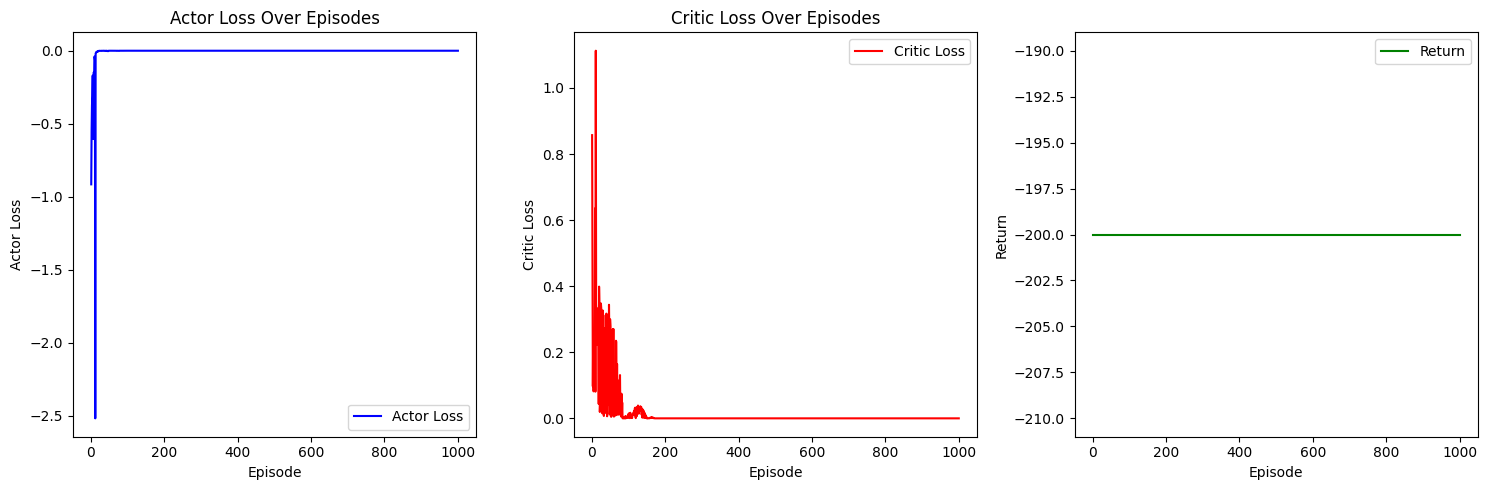

In [9]:
import matplotlib.pyplot as plt

# Actor Loss, Critic Loss ve Return grafiği çizme
def plot_training_stats(stats):
    episodes = range(1, len(stats['Actor Loss']) + 1)
    
    # Actor Loss Grafiği
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(episodes, stats['Actor Loss'], label="Actor Loss", color="blue")
    plt.xlabel("Episode")
    plt.ylabel("Actor Loss")
    plt.title("Actor Loss Over Episodes")
    plt.legend()

    # Critic Loss Grafiği
    plt.subplot(1, 3, 2)
    plt.plot(episodes, stats['Critic Loss'], label="Critic Loss", color="red")
    plt.xlabel("Episode")
    plt.ylabel("Critic Loss")
    plt.title("Critic Loss Over Episodes")
    plt.legend()

    # Return Grafiği
    plt.subplot(1, 3, 3)
    plt.plot(episodes, stats['Returns'], label="Return", color="green")
    plt.xlabel("Episode")
    plt.ylabel("Return")
   
    plt.legend()

    plt.tight_layout()
    plt.show()

# Eğitim tamamlandıktan sonra stats'ı kullanarak grafikleri çizdirin
plot_training_stats(stats)